# UTILIDADES DE LECTURA

* El código lo hice asumiendo que la carpeta del PH2 está en la misma carpeta que el Notebook.
* Algunas de estas funciones las saqué directamente de los paquetes debido a problemas para importar en mi versión de Python.

In [119]:
from glob import glob
from abc import ABCMeta, abstractmethod
from os.path import join, splitext, basename, abspath
from os import listdir
from skimage.io import imread
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
import math
from skimage import morphology
from skimage.measure import label, regionprops
import cv2
from skimage import measure
from scipy.ndimage import rotate
import math 

%matplotlib inline

warnings.filterwarnings("ignore")

class MissingAttributeException(Exception):
    def __init__(self, attribute):
        super(MissingAttributeException, self).__init__(
            'The <{}> attribute is not contained in the dataset'.format(attribute)
        )


class BaseDataset:
    __metaclass__ = ABCMeta

    def __init__(self, dataset_path):
        self.__dataset_path = abspath(dataset_path)
        self.__image_list = self.load_dataset(self.__dataset_path)
        self.__sample = self.__image_list

    @abstractmethod
    def load_dataset(self, dataset_path):
        '''
        It must return a vector of dictionary in the followed way (keys with * are mandatory):
        image_data = [
                        {
                            'image_filename': <* image filename>,
                            'imageName': <* image name>,
                            'ground_truth_filename': <ground_truth_filename>,
                            'class': <class number the image belong to>,
                            'labels': <vector of string labels associates with the image>
                        },
                        {...}
                    ]
        :param dataset_path: base path for the dataset
        :return: a list of dictionaries containing the dataset information. One entry per image in the dataset
        '''
        return None

    @abstractmethod
    def read_data(self, filename):
        return None

    @abstractmethod
    def has_class(self):
        return False

    @abstractmethod
    def has_labels(self):
        return False

    @abstractmethod
    def has_ground_truth(self):
        return False

    @property
    def image_names(self):
        return [i['imageName'] for i in self.__sample]

    @property
    def num_images(self):
        return len(self.__sample)

    def reset_sample(self):
        self.__sample = self.__image_list

    def set_sample(self, **kwargs):
        if 'percentage' in kwargs:
            p = kwargs['percentage']
            N = len(self.__image_list)
            rn = np.random.rand(N)
            j = np.argsort(rn)[0:int(np.floor(p * N))]
            self.__sample = [self.__image_list[i] for i in j]
        elif 'image_names' in kwargs:
            i_names = kwargs['image_names']
            self.__sample = [data for data in self.__image_list if data['imageName'] in i_names]
        elif 'image_indices' in kwargs:
            image_idxs = kwargs['image_indices']
            self.__sample = [self.__image_list[i] for i in image_idxs]
        else:
            print('No samples was selected. All images will be used.')
            self.reset_sample()

    def exclude_from_sample(self, **kwargs):
        if 'image_names' in kwargs:
            i_names = kwargs['image_names']
            self.__sample = [data for data in self.__sample if data['imageName'] not in i_names]
        elif 'image_indices' in kwargs:
            image_idxs = kwargs['image_indices']
            self.__sample = [self.__sample[i] for i in range(len(self.__sample)) if i not in image_idxs]
        else:
            print('No elements were excluded from the sample.')

    def get_image_data(self, idx_image):
        current_image = self.__sample[idx_image]

        if 'loaded' not in current_image or not current_image['loaded']:
            current_image['data'] = self.read_data(current_image['image_filename'])
            current_image['loaded'] = True

        return current_image['data']

    def get_ground_truth_data(self, idx_image):
        current_image = self.__sample[idx_image]

        if self.has_ground_truth():
            if 'ground_truth_loaded' not in current_image or not current_image['ground_truth_loaded']:
                current_image['ground_truth_data'] = self.read_data(current_image['ground_truth_filename'])
                current_image['ground_truth_loaded'] = True

            return current_image['ground_truth_data']
        else:
            raise MissingAttributeException('ground_truth_data')

    def get_image_class(self, idx_image):
        current_image = self.__sample[idx_image]

        if self.has_class():
            return current_image['class']
        else:
            raise MissingAttributeException('class')

    def get_image_labels(self, idx_image):
        current_image = self.__sample[idx_image]

        if self.has_labels():
            return current_image['labels']
        else:
            raise MissingAttributeException('labels')


class MPEG7Dataset(BaseDataset):
    """
    Concrete implementation of the MPEG-7 Dataset
    """

    def __init__(self, basepath):
        self.image_list = [{
                               'image_filename': fn,
                               'imageName': splitext(basename(fn))[0],
                               'ground_truth_filename': None,
                               'class': None,  # TODO,
                               'labels': None
                           } for fn in glob(join(basepath, 'MPEG7/original/*.gif'))]

class PH2Dataset(BaseDataset):
    """
    Concrete implementation of the MPEG-7 Dataset
    """

    def __init__(self, base_path):
        BaseDataset.__init__(self, base_path)

    def load_dataset(self, dataset_path):
        image_list = []
        images_base_folder = join(dataset_path, 'PH2 Dataset images')
        image_dirs = [f for f in listdir(images_base_folder) if not f.startswith('.')]

        #Reads the info in the XLSX file
        df = pd.read_excel(join(dataset_path, 'PH2_dataset.xlsx'))
        classes = []
        for i in range(len(image_dirs)):

            cell_common_nevus = df.iloc[i + 11, 2]
            cell_atypical_nevus = df.iloc[i + 11, 3]
            cell_melanoma = df.iloc[i + 11, 4]

            if cell_common_nevus == 'X':
                image_class = 1
            elif cell_atypical_nevus == 'X':
                image_class = 2
            else:
                image_class = 3

            classes.append({
                'name': df.iloc[i + 11, 0],
                'class': image_class
            })

        for image_folder_name in image_dirs:
            filename = join(images_base_folder, image_folder_name, image_folder_name + '_Dermoscopic_Image',
                            image_folder_name + '.bmp')
            ground_truth_filename = join(images_base_folder, image_folder_name, image_folder_name + '_lesion',
                                         image_folder_name + '_lesion.bmp')



            #image class
            results = list(filter(lambda all_classes: all_classes['name'] == image_folder_name, classes))
            if len(results) > 0:
                c = results[0]['class']
            else:
                c = 1

            image_list.append({
                'image_filename': filename,
                'imageName': image_folder_name,
                'ground_truth_filename': ground_truth_filename,
                'class': c,
                'labels': ['', ''] #TODO: llenar esto
            })

        return image_list

    def read_data(self, filename):
        return imread(filename)

    def has_class(self):
        return True

    def has_labels(self):
        return True

    def has_ground_truth(self):
        return True

In [120]:
def rgb_to_hsv(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

def rgb_to_lab(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2LAB)

In [121]:
dataset = PH2Dataset("PH2Dataset")

In [122]:
images = dataset.load_dataset("PH2Dataset")

# LECTURA DE LA IMAGEN

In [127]:
idd = 20
image1 = dataset.read_data(images[idd]["image_filename"])
image1_mask = dataset.read_data(images[idd]["ground_truth_filename"])
mask_3c = np.zeros((image1.shape), np.uint8)
mask_3c[:,:,0] = image1_mask
mask_3c[:,:,1] = image1_mask
mask_3c[:,:,2] = image1_mask
image1 = image1 * (mask_3c > 0)

# EXPERIMENTOS PARA EL CALCULO DE LA ASIMETRIA

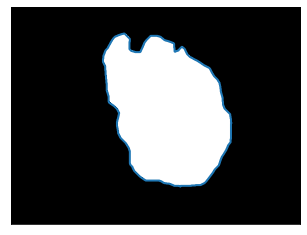

In [128]:
mascara = image1_mask
contours = measure.find_contours(mascara, 0.8)
fig, ax = plt.subplots()
ax.imshow(mascara, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# OBTENIENDO EL EJE MAYOR Y EJE MENOR Y USÁNDOLOS PARA CORREGIR LA ORIENTACIÓN DEL OBJETO

Longitud del eje mayor: 429.79707195849295
Longitud del eje menor: 294.625167584493


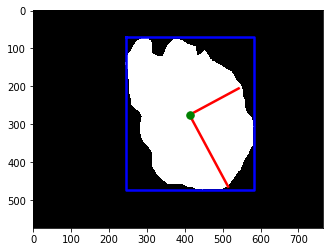

In [129]:
label_img = label(mascara)
props = regionprops(label_img)[0]
props.orientation
fig, ax = plt.subplots()
ax.imshow(mascara, cmap=plt.cm.gray)
print("Longitud del eje mayor:", props.major_axis_length)
print("Longitud del eje menor:",props.minor_axis_length)
y0, x0 = props.centroid
orientation = props.orientation
x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
ax.plot(x0, y0, '.g', markersize=15)

minr, minc, maxr, maxc = props.bbox
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-b', linewidth=2.5)

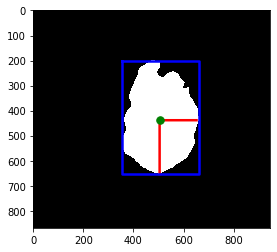

In [130]:
grados = grados if grados > 0 else 360-abs(grados)
grados = props.orientation*180/math.pi
rotate_img = rotate(mascara, (270-grados)) > 128
label_img = label(rotate_img)
props = regionprops(label_img)[0]
props.orientation
fig, ax = plt.subplots()
ax.imshow(rotate_img, cmap=plt.cm.gray)
y0, x0 = props.centroid
orientation = props.orientation
x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
ax.plot(x0, y0, '.g', markersize=15)

minr, minc, maxr, maxc = props.bbox
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-b', linewidth=2.5)

# FUNCIONES PARA EXTRACCIÓN DE CARACTERISTICAS

In [31]:
def get_lab_hsv_features(im, mask, features):
    #La imagen de entrada debe estar en el espacio RGB
    #Extraer el tamaño de la imagen de entrada y convertirla a LAB y HSV
    shape = np.shape(im)
    im_lab = rgb_to_lab(im)
    im_hsv = rgb_to_hsv(im)
    
    #Definir los canales  por separado
    s = im_hsv[:,:,1]
    v = im_hsv[:,:,2]
    
    a = im_lab[:,:,1]
    b = im_lab[:,:,2]
    #Definir listas vacías de canales h,s,v
    a_1 = []
    b_1 = []
    s_1 = []
    v_1= []
    
    #Recorrer cada posición i,j de la matriz de la imagen de entrada
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Condicional, si la máscara en la posición i,j es un array verdadero añadir
            #a cada canal del nuevo HSV el píxel en esta posición
            if((mask[i][j] == np.array([True, True, True])).all() ):
                s_1.append(s[i][j])
                v_1.append(v[i][j])
                a_1.append(a[i][j])
                b_1.append(a[i][j])
                
    #Utilizar features para guardar los valores de media, desviación estándar, kurtosis y sesgo
    #de cada uno de los canales h_1, s_1, v_1
    features['s_mean'] = np.mean(s_1)
    features['s_std'] = np.std(s_1)
    features['s_kurtosis'] = kurtosis(s_1)
    features['s_skew'] = skew(s_1)
    features['v_kurtosis'] = kurtosis(v_1)
    features['v_skew'] = skew(v_1)
    features['v_mean'] = np.mean(v_1)
    features['v_std'] = np.std(v_1)
    features['lab_a_mean'] = np.mean(a_1)
    features['lab_a_std'] = np.std(a_1)
    features['lab_a_kurtosis'] = kurtosis(a_1)
    features['lab_a_skew'] = skew(a_1)
    features['lab_b_kurtosis'] = kurtosis(b_1)
    features['lab_b_skew'] = skew(b_1)
    features['lab_b_mean'] = np.mean(b_1)
    features['lab_b_std'] = np.std(b_1)

    return features

def get_moments_hu(props, features):
    moments_hu = props.moments_hu
    moments_hu = np.sign(moments_hu) * np.log(np.abs(moments_hu))
    features['hu0'] = moments_hu[0]
    features['hu1'] = moments_hu[1]
    features['hu2'] = moments_hu[2]
    features['hu3'] = moments_hu[3]
    features['hu4'] = moments_hu[4]
    features['hu5'] = moments_hu[5]
    features['hu6'] = moments_hu[6]
    return features

def get_features_perimeter(mask, features):
    contours = measure.find_contours(mask, 0.8)
    features['perimeter'] = contours[0].shape[0]
    return features

def get_features_area(props, features):
    features['area'] = props.area
    features['convex_area'] = props.convex_area
    features['area_to_convex_ratio'] = props.area/props.convex_area
    features['compacity'] = props.perimeter**2/props.area
    features['roundness'] = 4*math.pi*props.area /(props.perimeter**2)
    features['area_perimeter_ratio'] = props.area / props.perimeter
    features['elongation'] = props.major_axis_length/props.minor_axis_length
    features['major_axis_length'] = props.major_axis_length
    features['minor_axis_length'] = props.minor_axis_length
    features['solidity1'] = props.area/props.convex_area
    features['solidity2'] = props.area / props.filled_area
    return features

#Definir función para extraer características del espacio RGB
def get_rgb_features(im,mask, features):
    #Crear una matriz del mismo tamaño de la imagen de entrada, leer los canales R,G,B y 
    #crear listas vacías donde se aplica la máscara
    shape = np.shape(im)
    r = im[:,:,0]
    g = im[:,:,1]
    b = im[:,:,2]
    r_1 = []
    g_1 = []
    b_1 = []
    #Recorrer las posiciones i,j de la matriz de la imagen de entrada
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Condicional, si la máscara en la posición i,j es un array de True, añadir
            #a cada canal del nuevo espacio RGB el píxel en esta posición
            if( (mask[i][j] == np.array([True, True, True])).all() ): 
                r_1.append(r[i][j])
                g_1.append(g[i][j])
                b_1.append(b[i][j])
    #Utilizar features para guardar los valores de media, desv.estandar, kurtosis y sesgo
    #de los canales r_1,g_1,b_1
    features['r_mean'] = np.mean(r_1)
    features['r_std'] = np.std(r_1)
    features['r_kurtosis'] = kurtosis(r_1)
    features['r_skew'] = skew(r_1)
    features['g_mean'] = np.mean(g_1)
    features['g_std'] = np.std(g_1)
    features['b_kurtosis'] = kurtosis(b_1)
    features['b_skew'] = skew(b_1)
    features['b_mean'] = np.mean(b_1)
    features['b_std'] = np.std(b_1)
    features['g_kurtosis'] = kurtosis(g_1)
    features['g_skew'] = skew(g_1)
    return features

In [132]:
def features_pipeline(img, mask):
    #Crear el diccionario para guardar las características
    features = {}
    label_img = label(mask)
    props = regionprops(label_img)[0]
    mask_3c = np.zeros((img.shape), np.uint8)
    mask_3c[:,:,0] = mask
    mask_3c[:,:,1] = mask
    mask_3c[:,:,2] = mask
    features = get_moments_hu(props, features)
    features = get_features_area(props, features)
    features = get_rgb_features(img,mask_3c,features)
    features = get_lab_hsv_features(img,mask_3c,features)
    features = get_features_perimeter(mask, features)
    return features

# EXTRACCION DE CARACTERISTICAS CON UNA SOLA IMAGEN

In [133]:
features_pipeline(image1, image1_mask > 0)

(574, 765)


{'hu0': -1.7470873915341298,
 'hu1': -5.533983490212998,
 'hu2': -8.678233820939855,
 'hu3': -11.24796194942319,
 'hu4': -21.548832507522242,
 'hu5': -14.7181359674896,
 'hu6': -21.566592034354677,
 'area': 97375,
 'convex_area': 102601,
 'area_to_convex_ratio': 0.9490648239295914,
 'compacity': 18.573493849764613,
 'roundness': 0.6765754852589798,
 'area_perimeter_ratio': 72.40639616648279,
 'elongation': 1.4587927958844018,
 'major_axis_length': 429.79707195849295,
 'minor_axis_length': 294.625167584493,
 'solidity1': 0.9490648239295914,
 'solidity2': 1.0,
 'r_mean': 173.11346854942235,
 'r_std': 26.329337354070773,
 'r_kurtosis': 0.002170659817012588,
 'r_skew': 0.26127215262954273,
 'g_mean': 108.5282567394095,
 'g_std': 21.855152995760584,
 'b_kurtosis': 2.268091187182671,
 'b_skew': 0.8524409078809834,
 'b_mean': 76.9192297817715,
 'b_std': 18.559484561430256,
 'g_kurtosis': 0.8255869125123358,
 'g_skew': 0.5888168707160605,
 's_mean': 142.25506546854942,
 's_std': 17.63651654029

# POR HACER: UN LOOP PARA SACAR LAS CARACTERISTICAS PARA TODAS LAS IMÁGENES Y ARMAR EL PANDAS.